In [34]:
# 1.1) Importar bibliotecas
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt

df = pd.read_csv("dataset_13.csv")

# 1) Shape
print("Linhas, Colunas:", df.shape)

# 2) Colunas
print("Colunas:", df.columns.tolist())

# 3) Tipos e non-null
df.info()

# 4) Preview rápido
display(df.head())


Linhas, Colunas: (186, 8)
Colunas: ['cpu_cores', 'ram_gb', 'latencia_ms', 'armazenamento_tb', 'sistema_operacional', 'tipo_hd', 'tipo_processador', 'tempo_resposta']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   cpu_cores            185 non-null    float64
 1   ram_gb               186 non-null    int64  
 2   latencia_ms          168 non-null    float64
 3   armazenamento_tb     168 non-null    float64
 4   sistema_operacional  186 non-null    object 
 5   tipo_hd              168 non-null    object 
 6   tipo_processador     186 non-null    object 
 7   tempo_resposta       186 non-null    float64
dtypes: float64(4), int64(1), object(3)
memory usage: 11.8+ KB


,cpu_cores,ram_gb,latencia_ms,armazenamento_tb,sistema_operacional,tipo_hd,tipo_processador,tempo_resposta
0,10.0,10,197.51,0.512,MacOS,SSD,Apple Silicon,84.53
1,13.0,15,298.33,0.512,Linux,SSD,Intel,62.30
2,13.0,11,195.98,0.256,Linux,HDD,Intel,71.06
3,7.0,8,182.40,0.256,Linux,SSD,Intel,124.72
4,5.0,4,123.57,1.000,MacOS,NaN,Apple Silicon,181.35


Estatísticas Descritivas

In [ ]:
# 1.1) Estatísticas resumidas
desc = df.describe(include='all').T
desc['nulos'] = df.isnull().sum()
display(desc)
# preencher HD faltante
df['tipo_hd'] = df['tipo_hd'].fillna('Missing')

# remover ou preencher latência e armazenamento
df = df.dropna(subset=['latencia_ms','armazenamento_tb'])



,count,unique,top,freq,mean,std,min,25%,50%,75%,max,nulos
cpu_cores,185.0,NaN,NaN,NaN,8.637838,4.00593,2.0,5.0,8.0,12.0,15.0,1
ram_gb,186.0,NaN,NaN,NaN,8.956989,3.988941,4.0,5.0,9.0,12.0,18.0,0
latencia_ms,168.0,NaN,NaN,NaN,159.443631,86.196289,4.04,99.1475,156.245,235.4625,298.33,18
armazenamento_tb,168.0,NaN,NaN,NaN,0.902,0.654491,0.256,0.256,0.512,1.0,2.0,18
sistema_operacional,186,3,MacOS,65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
tipo_hd,168,2,HDD,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18
tipo_processador,186,3,Apple Silicon,65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
tempo_resposta,186.0,NaN,NaN,NaN,136.983441,88.137574,53.6,73.345,104.295,175.5575,403.88,0


Histogramas/Distribuições

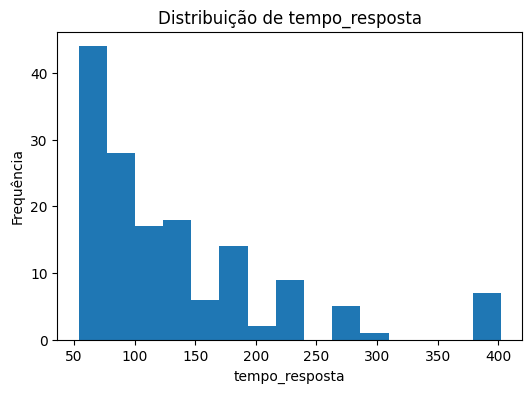

In [ ]:
#histograma de tempo_resposta
plt.figure(figsize=(6,4))
plt.hist(df['tempo_resposta'].dropna(), bins=15)
plt.title('Distribuição de tempo_resposta')
plt.xlabel('tempo_resposta')
plt.ylabel('Frequência')
plt.show()




Modelo e Diagnóstico

In [ ]:
# 3.1) Identificar variáveis categóricas
cat_cols = ['sistema_operacional', 'tipo_hd', 'tipo_processador']

# 3.2) Tratar valores nulos em tipo_hd
df['tipo_hd'] = df['tipo_hd'].fillna('Missing')
# 3.2.b) Tratar valores faltantes em latencia_ms e armazenamento_tb
# (ou preenchendo com mediana, ou removendo linhas)
df[['latencia_ms','armazenamento_tb']] = df[['latencia_ms','armazenamento_tb']] \
    .fillna(df[['latencia_ms','armazenamento_tb']].median())



# 3.3) Criar dummies…
df_model = pd.get_dummies(
    df,
    columns=['sistema_operacional','tipo_hd','tipo_processador'],
    drop_first=True
)

# 3.4) Remover dummy colinear (ex.: Apple Silicon)
df_model = df_model.drop(columns=['tipo_processador_Apple Silicon'])

# 3.5) Definir y e X
y = df_model['tempo_resposta']
X = df_model.drop(columns=['tempo_resposta'])
X = sm.add_constant(X)

# 3.6) Converter para float
X = X.astype(float)
y = pd.to_numeric(y, errors='raise')


import numpy as np
X = X.replace([np.inf, -np.inf], np.nan)
mask = X.notnull().all(axis=1)
X = X.loc[mask]
y = y.loc[mask]
# ────────────────────────

# 4) Ajuste do modelo
model_full = sm.OLS(y, X).fit()
print(model_full.summary())





                            OLS Regression Results                            
Dep. Variable:         tempo_resposta   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     53.58
Date:                Mon, 05 May 2025   Prob (F-statistic):           5.16e-41
Time:                        11:54:54   Log-Likelihood:                -763.31
No. Observations:                 150   AIC:                             1547.
Df Residuals:                     140   BIC:                             1577.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

Diagnóstico de multicolinearidade

In [39]:
vif_data = pd.DataFrame({
    'variável': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
display(vif_data)


,variável,VIF
0,const,17.202182
1,cpu_cores,10.833923
2,ram_gb,10.977441
3,latencia_ms,1.038978
4,armazenamento_tb,1.132964
5,sistema_operacional_MacOS,1.760124
6,sistema_operacional_Windows,1.469961
7,tipo_hd_Missing,1.121985
8,tipo_hd_SSD,1.136088
9,tipo_processador_Intel,1.388630


Diagnóstico de heterocedasticidade

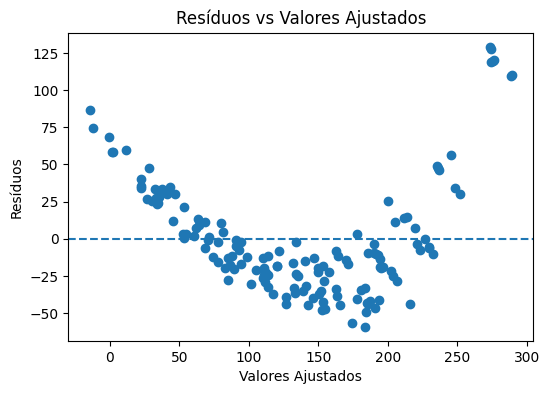

{'Lagrange multiplier': np.float64(26.29401735633988), 'p-value': np.float64(0.0018284430465239508), 'f-value': np.float64(3.3063724083860957), 'f p-value': np.float64(0.0010947643467905854)}
Breusch–Pagan p-value: 0.0018284430465239508


In [40]:
# 6.1) Resíduos vs Ajustados
fitted = model_full.fittedvalues
resid   = model_full.resid

plt.figure(figsize=(6,4))
plt.scatter(fitted, resid)
plt.axhline(0, linestyle='--')
plt.xlabel('Valores Ajustados')
plt.ylabel('Resíduos')
plt.title('Resíduos vs Valores Ajustados')
plt.show()

# 6.2) Teste de Breusch-Pagan
bp_test = sms.het_breuschpagan(resid, model_full.model.exog)
labels = ['Lagrange multiplier', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, bp_test)))
bp = sms.het_breuschpagan(model_full.resid, model_full.model.exog)
print("Breusch–Pagan p-value:", bp[1])



Comparação entre Modelos

In [ ]:
# 7.1) Escolha uma variável para excluir (ex.: aquela de maior VIF ou não significativa)
vars_to_drop = ['armazenamento_tb']  

X2 = X.drop(columns=vars_to_drop)
model_reduced = sm.OLS(y, X2).fit()

# 7.2) Resumos lado a lado
print("Modelo Completo:")
print(model_full.summary().tables[1])
print("\nModelo Reduzido (sem {}):".format(vars_to_drop))
print(model_reduced.summary().tables[1])

# 7.3) Teste F para comparar modelos
f_test = model_full.compare_f_test(model_reduced)
print("\nTeste F (Full vs Reduced): F = {:.3f}, p-value = {:.3f}, DF diff = {}".format(*f_test))


Modelo Completo:
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                         309.8846     13.756     22.527      0.000     282.687     337.082
cpu_cores                     -27.6180      2.787     -9.908      0.000     -33.129     -22.107
ram_gb                          9.4402      2.741      3.444      0.001       4.022      14.859
latencia_ms                    -0.0694      0.039     -1.785      0.076      -0.146       0.007
armazenamento_tb               -6.4568      5.505     -1.173      0.243     -17.340       4.427
sistema_operacional_MacOS     -10.2202      9.246     -1.105      0.271     -28.500       8.060
sistema_operacional_Windows    -9.0955      8.574     -1.061      0.291     -26.047       7.856
tipo_hd_Missing                 7.0039     11.381      0.615      0.539     -15.497      29.505
tipo_hd_SSD            